In [10]:
import numpy as np
import torch
from deep_parity.boolean_cube import generate_all_binary_arrays, fourier_transform
import polars as pl

from plotnine import ggplot, aes, geom_line, geom_bar, geom_histogram, facet_wrap

In [22]:
import numpy as np
import torch
from itertools import combinations

def generate_all_binary_arrays(n: int):
    numbers = np.arange(2**n, dtype=np.uint32)
    return ((numbers[:, np.newaxis] >> np.arange(n)[::-1]) & 1).astype(np.uint8)

def fourier_transform(u, normalize=True):
    _, n = u.shape
    m = int(np.log2(n))
    assert n == 1 << m, 'n must be a power of 2'
    x = u[..., np.newaxis]
    for _ in range(m)[::-1]:
        x = torch.cat((x[..., ::2, :] + x[..., 1::2, :], x[..., ::2, :] - x[..., 1::2, :]), dim=-1)
    return x.squeeze(-2) / 2**(m / 2) if normalize else x.squeeze(-2)

def generate_random_degree_11_function(n=18, degree=11, distribution='gaussian', scale=1.0):
    """
    Generate a random function on {-1, 1}^n that depends only on degree 11 terms.
    
    Parameters:
    n (int): Dimension of the boolean cube (default: 18)
    degree (int): Degree of the terms to consider (default: 11)
    distribution (str): Type of random distribution to use ('gaussian' or 'uniform')
    scale (float): Scale factor for the random numbers
    
    Returns:
    torch.Tensor: The generated function values on {-1, 1}^n
    """
    # Create a vector of zeros
    fourier_coeffs = torch.zeros(2**n)
    
    # Generate indices for degree 11 terms
    degree_11_indices = []
    for comb in combinations(range(n), degree):
        index = sum(2**i for i in comb)
        degree_11_indices.append(index)
    
    # Generate random numbers for degree 11 terms
    num_coeffs = len(degree_11_indices)
    if distribution == 'gaussian':
        random_coeffs = torch.randn(num_coeffs) * scale
    elif distribution == 'uniform':
        random_coeffs = (torch.rand(num_coeffs) * 2 - 1) * scale
    else:
        raise ValueError("Distribution must be 'gaussian' or 'uniform'")
    
    # Assign random numbers to degree 11 indices
    fourier_coeffs[degree_11_indices] = random_coeffs
    
    # Perform inverse Fourier transform
    function_values = fourier_transform(fourier_coeffs.unsqueeze(0)).squeeze(0)
    
    return function_values

# Example usage
n = 18
degree = 11
random_function = generate_random_degree_11_function(n, degree, distribution='uniform', scale=1.0)

print(f"Generated function on {{-1, 1}}^{n} with {degree}-degree terms:")
print(f"Shape of the function: {random_function.shape}")
print(f"First 10 values: {random_function[:10]}")
print(f"Last 10 values: {random_function[-10:]}")

Generated function on {-1, 1}^18 with 11-degree terms:
Shape of the function: torch.Size([262144])
First 10 values: tensor([-0.0606, -0.3075,  0.0769,  0.1090,  0.1653, -0.1542, -0.2759,  0.1993,
        -0.2706,  0.3755])
Last 10 values: tensor([-0.3755,  0.2706, -0.1993,  0.2759,  0.1542, -0.1653, -0.1090, -0.0769,
         0.3075,  0.0606])


In [6]:
import polars as pl

def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n)
    all_degrees = all_binary_data.sum(axis=1)
    all_parities = all_degrees % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
        'degree': all_degrees
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1))
    )
    return base_df

boolean_df = make_base_parity_dataframe(n)

In [23]:
rand_df = boolean_df.with_columns(rand_fn = pl.Series(random_function.numpy()))

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 211'. Pick better value with 'binwidth'.


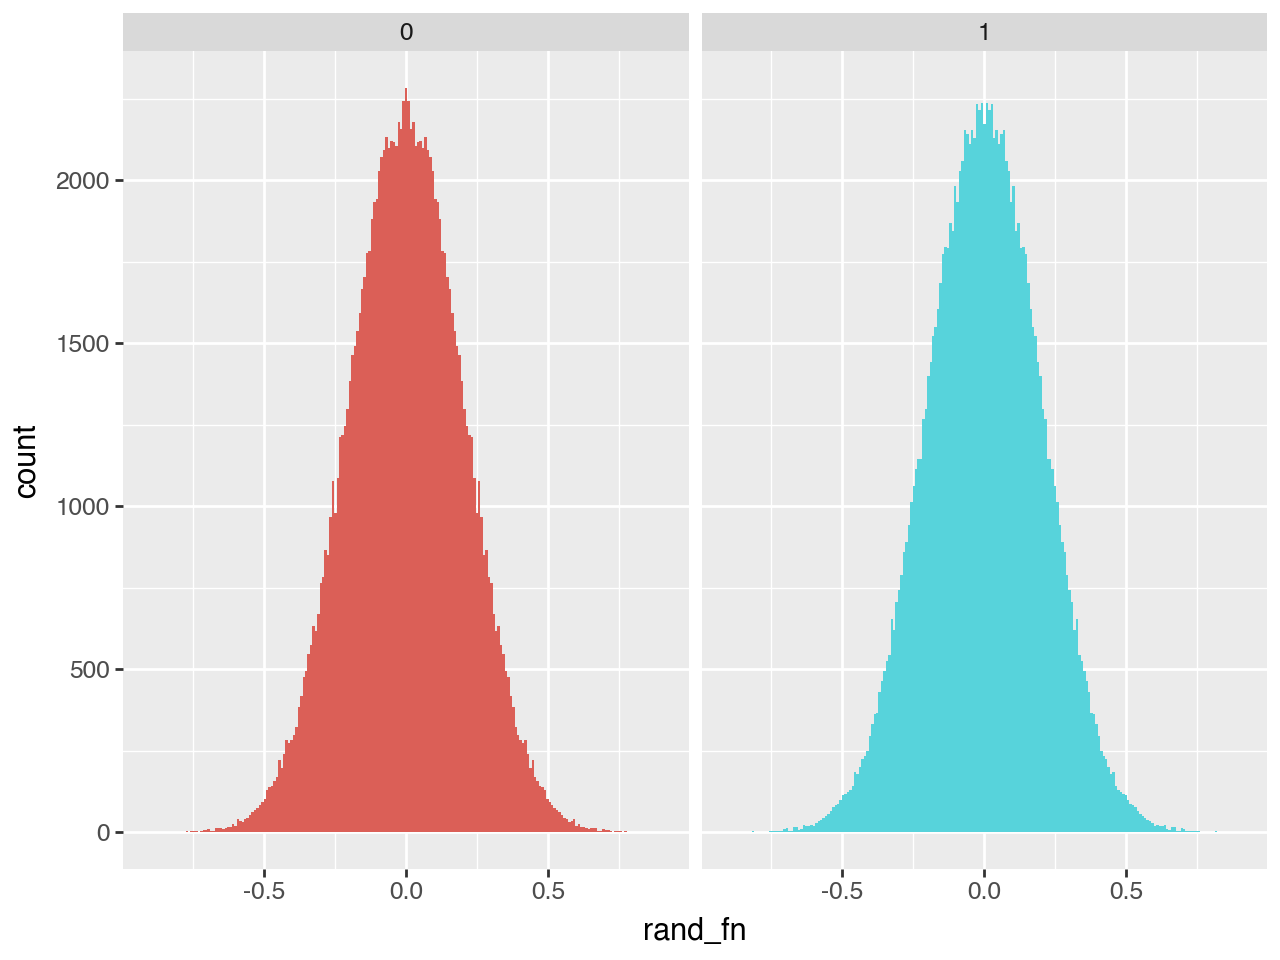

In [24]:
ggplot(rand_df, aes(x='rand_fn', fill='factor(parities)')) + geom_histogram(show_legend=False) + facet_wrap('~parities')

In [3]:
from torch.nn.functional import relu

def _rlf(weights, vals):
    return relu(weights @ vals.T)


In [4]:
rlf = torch.vmap(_rlf, in_dims=(0, None))

In [5]:
weights = torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float64)
weights = torch.sign((-1 * weights) + 0.5)

In [6]:
rand_vals = rlf(weights, all_bn)

In [7]:
ft = fourier_transform(rand_vals, n)

In [8]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n)
    all_degrees = all_binary_data.sum(axis=1)
    all_parities = all_degrees % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
        'degree': all_degrees
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1))
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    ft = fourier_transform(tensor.T.to('cuda'))
    ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df

boolean_df = make_base_parity_dataframe(n)

In [12]:
ft_df = pl.DataFrame({str(i): vals.squeeze().numpy() for i, vals in enumerate(ft.split(1))})
data = (
    pl.concat([boolean_df, ft_df], how='horizontal')
    .unpivot(index=['bits', 'parities', 'degree', 'indices'])
    .with_columns(pl.col('variable').str.to_integer())
)
data.head()

bits,parities,degree,indices,variable,value
"array[u8, 10]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],0,39.375
"[0, 0, … 1]",1,1,[9],0,16.0
"[0, 0, … 0]",1,1,[8],0,16.0
"[0, 0, … 1]",0,2,"[8, 9]",0,4.375
"[0, 0, … 0]",1,1,[7],0,16.0


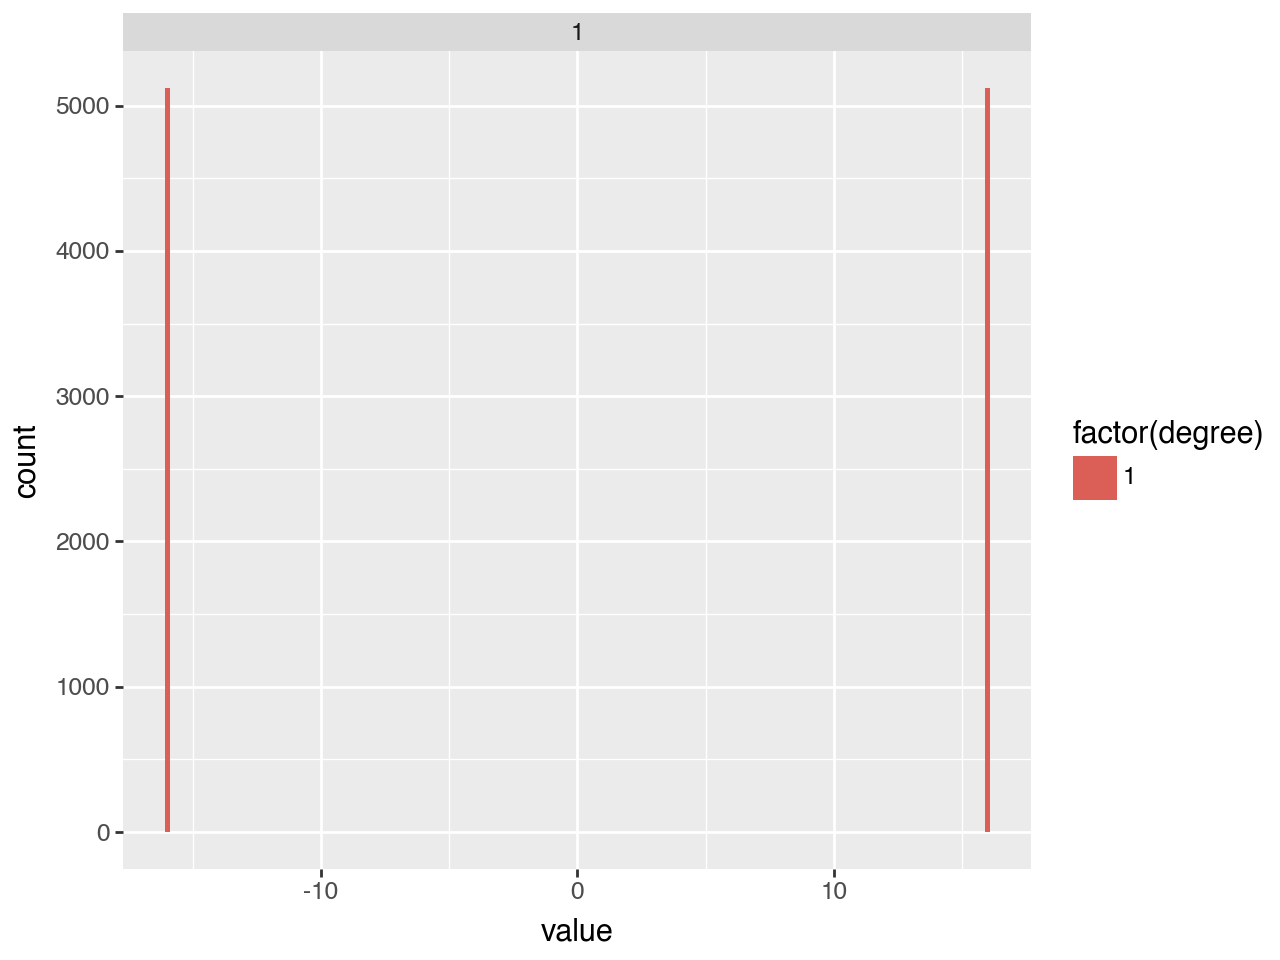

In [22]:
ggplot(data.filter(pl.col('degree').eq(1)), aes(x='value', fill='factor(degree)')) + geom_histogram(binwidth=0.2) + facet_wrap('~degree')

In [193]:
data.filter(pl.col('degree').eq(0) & pl.col('value').lt(0))

bits,parities,degree,indices,variable,value
"array[u8, 12]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],15,-0.875
"[0, 0, … 0]",0,0,[],23,-0.875
"[0, 0, … 0]",0,0,[],27,-0.875
"[0, 0, … 0]",0,0,[],29,-0.875
"[0, 0, … 0]",0,0,[],30,-0.875
…,…,…,…,…,…
"[0, 0, … 0]",0,0,[],4066,-0.375
"[0, 0, … 0]",0,0,[],4068,-0.375
"[0, 0, … 0]",0,0,[],4072,-0.375


In [25]:
2 ** 6 * 720

46080